In [1]:
import wandb
from stable_baselines3 import PPO
from train import Train
from eval import _evaluate_policy
from pathlib import Path
from cyclesgym.paths import PROJECT_PATH
import numpy as np
import matplotlib.pyplot as plt
from cyclesgym.envs.implementers import RotationPlanter
import pandas as pd
import wandb
import csv
import pathlib
from matplotlib.cm import get_cmap

In [ ]:
def set_size(width, fraction=1, subplots=(1, 1)):
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [ ]:
text_width = 397.48499

plt.rcParams['text.usetex'] = True

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["font.family"] = "Times New Roman"

color = get_cmap('Accent').colors

In [ ]:
config = dict(train_start_year=1980, train_end_year=1998, eval_start_year=1998, eval_end_year=2016,
              total_timesteps=1000000, eval_freq=1000, n_steps=80, batch_size=64, n_epochs=10, run_id=0,
              norm_reward=True, method="PPO", verbose=1, n_process=8, device='auto')
api = wandb.Api()

runs = api.runs("koralabs/experiments_crop_planning")
selected_runs = ['1hxh40tm', '1p4iajyk']

actions = []
rewards = []
titles = []
for run in runs:
    dir = [dir for dir in PROJECT_PATH.joinpath('wandb').iterdir() if run.path[-1] in str(dir)]
    if len(dir) > 0 and run.path[-1] in selected_runs:
        dir = dir[0]
        file = dir.joinpath('files/models/eval_det/best_model')
        run_config = run.config
        eval_env_class = 'CropPlanningFixedPlanting'
        if run_config.get('non_adaptive', False) == 'True':
            eval_env_class = 'CropPlanningFixedPlantingRotationObserver'
        config['eval_env_class'] = eval_env_class
        
        envs = Train(config).create_envs()

        model = PPO.load(file, device='cpu')

        env = envs[1]
        
        if 'Rotation' in eval_env_class:
            title = r'\textsc{nonadaptive}'NON
        else:
            title = r'SoilN observations'
            
        mean_reward, std_reward, episode_actions, episode_rewards, episode_probs, episode_action_rewards = \
            _evaluate_policy(model, env,  n_eval_episodes=1, deterministic=True)
        
        actions.append(episode_actions)
        rewards.append(episode_action_rewards)
        titles.append(title)

In [ ]:
[sum(r)/19 for r in rewards]

In [ ]:
def plot_two_policies(actions, rewards, titles, figsize): 
    fig, ax = plt.subplots(2, 2, figsize=figsize, sharex=True, sharey='row')
    x = 1980 + np.arange(19)
    for i, (episode_actions, episode_rewards, title) in enumerate(zip(actions, rewards, titles)):
        episode_actions = episode_actions.squeeze()
        planting_date = episode_actions[:, 1]
        planting_date = 90 + planting_date * 7
        crop = episode_actions[:, 0]

        ax[0,i].bar(x, np.array(episode_rewards)/1000., color=[color[c] for c in crop])
        ax[0,i].set_title(title)
        ax[1,i].scatter(x, planting_date, color=[color[c] for c in crop], s=100, marker='o')
        ax[1,i].set_xticks(x)
        ax[1,i].set_xticklabels(x, rotation=40)
        ax[1,i].set_xlim(min(x) - 0.8, max(x) + 0.8)
    
    ax[1,0].set_ylabel(r'Planting date [DOY]')
    ax[0,0].set_ylabel(r'Year reward [k\$]')
    ax[1,1].set_xlabel(r'Years')
    ax[1,1].xaxis.set_label_coords(-0.1, -0.3)
    #fig.autofmt_xdate()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.legend()
    plt.savefig(PROJECT_PATH.joinpath('figures/crop_planning_policies/crop_planning_policies.pdf'), 
                bbox_inches='tight')
    plt.show()

In [ ]:
plot_two_policies(actions, rewards, titles, set_size(text_width, fraction=1, subplots=(2, 2)))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


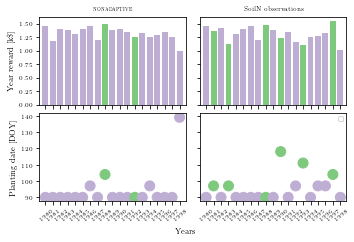

In [97]:
plot_two_policies(actions, rewards, titles, set_size(text_width, fraction=1, subplots=(2, 2)))